Now let's attempt to classify GOTO light curves with the FATS features and a random forest classifier. For this task we'll group the GOTO light curves into two classes:
- flare/variable star
- supernova/transient

To train and test the classifier, we'll use a simulated data set that I've created which has light curves for
- M-dwarf stellar flares
- Supernovae
- Variable stars

The light curves have been created to replicate what GOTO would observe (given information about the filter and cadence).

In [1]:
import utils
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

In [12]:
# Method to plot confusion matrix
# class_labels are the possible predicted classes
def plot_confusion_matrix(true_labels, predicted_labels, classes, title):
    
    # Create confusion matrix
    cm = sk.metrics.confusion_matrix(true_labels, predicted_labels)
    
    # Normalise confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    
    # Define colourmap for plot
    cmap=plt.cm.Oranges
    
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="8%", pad=0.2)
    
    ax.figure.colorbar(im, cax=cax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    #ax.tick_params(axis='y', pad=10)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="center",
             rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), ha="center",
             rotation_mode="anchor", rotation=90)
    

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' #if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

We need to prepare the data for training and testing. The data needs to be split into __features__ and __labels__.

In [3]:
# Read in features
sim_data = pd.read_csv('simulated_fats_features.csv')

# Split into features and labels
labels = sim_data['type']

# Put m-dwarfs and variable stars in one group
labels = labels.replace(['m_dwarf', 'varstar'], 'flare/varstar')
labels = labels.replace(['sn', 'at'], 'sn/transient')
features = sim_data.drop(columns=['type'])

Sometimes features will contain empty or values that don't make sense (e.g. infinities). A common practice in machine learning is to sometimes fill in the empty values with the median value of all other data for that feature.

In [4]:
# Handle nan data - replace with median values
nan_columns = features.columns[features.isna().any()].to_list()

for col in nan_columns:
    
    fd = features[col]
    
    # Get mean value of column
    median_val = fd.median()
    idx = fd[pd.isna(fd)].index.values
    
    # Set nan values to median
    fd.iloc[idx] = median_val

/home/umar/.local/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


It is important to have a __balanced__ training set, where there are equal numbers of samples from each class. Otherwise the classifier will struggle to classify accurately. So let's create a balanced training set. We have a total of 55442 simulated light curves, and split the data into a 20\% balanced training set and an 80\% test set.

In [6]:
# Split into training and test set
X_train, X_test, y_train, y_test = utils.balanced_train_test_split(features, labels, test_size=0.8, random_state=1)
print('Training set size: ', len(X_train))
print('Test set size: ', len(X_test))

Training set size:  11088
Test set size:  44354


For classification, we'll use the random forest algorithm.

Next, we use five-fold cross-validation to determine the best hyperparameters and use the $F_1$ score as the performance metric. The $F_1$ score is defined as

$$F_1 = 2 \times \frac{\mathrm{purity} \times \mathrm{completeness}}{\mathrm{purity} + \mathrm{completeness}}$$

The $F_1$ score averaged over all classes, the macro $F_1$ score is used.

The hyperparameters that we'll vary are
- `n_trees`: the number of decision trees in the random forest
- `max_depth`: the maximum number of splits performed by each decision tree
- `max_features`: the maximum number of features sampled by the tree at each split

In [7]:
# Try classification with random forest
# Create parameter grid to search for optimal hyperparameters
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [12, 16],
              'max_features':['sqrt', 'log2']}

# Do a parameter search to find best parameters, using F1 macro as a score
for params in ParameterGrid(param_grid):
    
    # Get individual values
    n_trees = params['n_estimators']
    depth = params['max_depth']
    max_features = params['max_features']
    
    # Define classifier
    rf = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=0)
    
    # Get cross-validation scores
    cv_f1_macro = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
    
    mean_f1_macro = np.mean(cv_f1_macro)
    std_f1_macro = np.std(cv_f1_macro)
    
    print('F1 macro score: {0:.2f} +/- {1:.2f}'.format(np.mean(cv_f1_macro), np.std(cv_f1_macro)))
    print(params)
    print('--------------------------------------------------------------------------------------')

F1 macro score: 1.00 +/- 0.00
{'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 100}
--------------------------------------------------------------------------------------
F1 macro score: 1.00 +/- 0.00
{'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 200}
--------------------------------------------------------------------------------------
F1 macro score: 1.00 +/- 0.00
{'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 300}
--------------------------------------------------------------------------------------
F1 macro score: 1.00 +/- 0.00
{'max_depth': 12, 'max_features': 'log2', 'n_estimators': 100}
--------------------------------------------------------------------------------------
F1 macro score: 1.00 +/- 0.00
{'max_depth': 12, 'max_features': 'log2', 'n_estimators': 200}
--------------------------------------------------------------------------------------
F1 macro score: 1.00 +/- 0.00
{'max_depth': 12, 'max_features': 'log2', 'n_estimators': 300}
-------

We see that on the simulated data, the random forest classifier performs perfectly with all the different hyperparameters. Next, we use an optimized classifier and classify the test data.

In [8]:
best_rf = RandomForestClassifier(n_estimators=300, max_depth=16, max_features='sqrt' ,random_state=1)

best_rf.fit(X_train, y_train)

# Get class predictions and prediction probabilities
y_pred = best_rf.predict(X_test)
y_probabilities = best_rf.predict_proba(X_test)

Let's see the confusion matrix for the test data.

Overall accuracy: 1.00


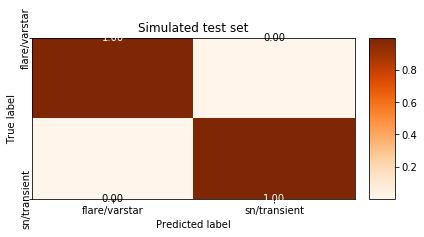

In [13]:
accuracy = sk.metrics.accuracy_score(y_test, y_pred)
print('Overall accuracy: {0:.2f}'.format(accuracy))

class_names = best_rf.classes_
confusion_matrix = plot_confusion_matrix(y_test, y_pred, class_names, title='Simulated test set')

fig = confusion_matrix.get_figure()

Now let's see how the classifier performs on real data. We follow the same steps as above, and use the optimized classifier to classify real GOTO light curves.

In [14]:
# Read in real data features
real_data = pd.read_csv('real_marshall_fats_features.csv')
real_data = real_data.replace(['star', 'varstar'], 'flare/varstar')
real_data = real_data.replace(['sn', 'at'], 'sn/transient')
real_data = real_data.replace('IR', np.nan)
real_data = real_data.dropna()    # There is one source classified as 'Infrared', we discard this

# Split into features and labels
real_labels = real_data['type']
real_ids = real_data['identifier']
real_features = real_data.drop(columns=['type', 'identifier'])

In [15]:
# Make predictions
real_pred = best_rf.predict(real_features)
real_prob = best_rf.predict_proba(real_features)

Overall accuracy: 0.90


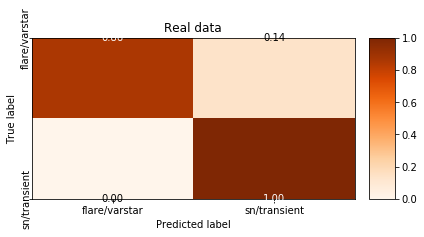

In [16]:
results_list = []
for pred, prob, true, idt in zip(real_pred, real_prob, real_labels, real_ids):
    
    p_star_var = prob[0].round(2)
    p_sn = prob[1].round(2)
    #p_varstar = prob[2].round(2)
    
    #print(pred , prob, true, idt)
    
    # Create a dictionary to store results
    results = {'identifier':idt,
               'true_type':true,
               'predicted_type':pred,
               'prob_star_varstar':p_star_var,
               'prob_sn':p_sn}
               #'prob_varstar':p_varstar}
    
    results_list.append(results)

accuracy = sk.metrics.accuracy_score(real_labels, real_pred)
print('Overall accuracy: {0:.2f}'.format(accuracy))

class_names = best_rf.classes_
confusion_matrix = plot_confusion_matrix(real_labels, real_pred, class_names, 'Real data')

fig = confusion_matrix.get_figure()
fig.savefig('rf_confusion_matrix_real_data.svg', format='svg', dpi=300, bbox_inches='tight')

In [17]:
# Create dataframe to store results
results_df = pd.DataFrame(results_list)

Let's look at the classification probabilities of the real data that were classified as supernova/transient

In [19]:
results_df[results_df['predicted_type']=='sn/transient']

,identifier,predicted_type,prob_sn,prob_star_varstar,true_type
10,IRAS 16138-2004,sn/transient,0.63,0.37,flare/varstar
13,V* CX Oph,sn/transient,0.53,0.47,flare/varstar
19,V* PT Cyg,sn/transient,0.53,0.47,flare/varstar
31,V* V824 Aql,sn/transient,0.64,0.36,flare/varstar
32,V* V1258 Aql,sn/transient,0.65,0.35,flare/varstar
46,IRAS 19037-1122,sn/transient,0.54,0.46,flare/varstar
48,IRAS 18547+1254,sn/transient,0.53,0.47,flare/varstar
51,SN 2019bpc,sn/transient,0.75,0.25,sn/transient
52,SN 2019cea,sn/transient,0.82,0.18,sn/transient
53,AT 2019ch,sn/transient,0.81,0.19,sn/transient


We see that all the non-sn objects classified as sn/transient have classification probabilities $<$ 0.64. A majority of correctly classified sn/transient objects have classification probabilities > 0.7, with only three (two unclassified transients, and one supernova) having probabilities below 0.7.